# Прогнозирование временных рядов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, TheilSenRegressor, HuberRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
RANDOM_STATE=177013

In [3]:
df = pd.read_csv('PJME_hourly.csv')

In [4]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## Приведение к правильному формату

In [5]:
df = pd.read_csv('PJME_hourly.csv', index_col=['Datetime'], parse_dates=['Datetime'])

In [6]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


Также следует проверить, идут ли даты по порядку:

In [7]:
df.index.is_monotonic_increasing

False

И при необходимости отсортировать данные:

In [8]:
df = df.sort_index()

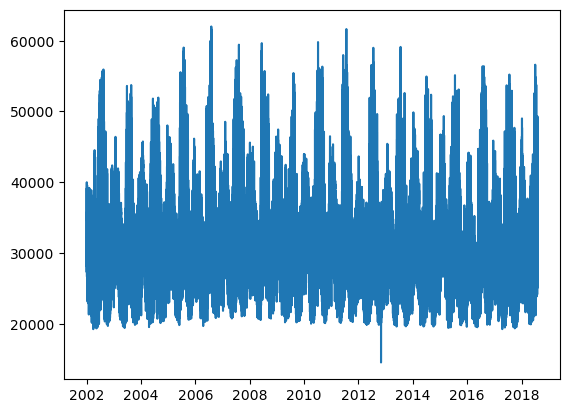

In [9]:
plt.plot(df);

## Ресемплинг

In [10]:
df.resample('1M').sum()

,PJME_MW
Datetime,
2002-01-31,23089022.0
2002-02-28,20320720.0
2002-03-31,21483191.0
2002-04-30,20516472.0
2002-05-31,20886798.0
...,...
2018-04-30,19694352.0
2018-05-31,21278364.0
2018-06-30,23050418.0


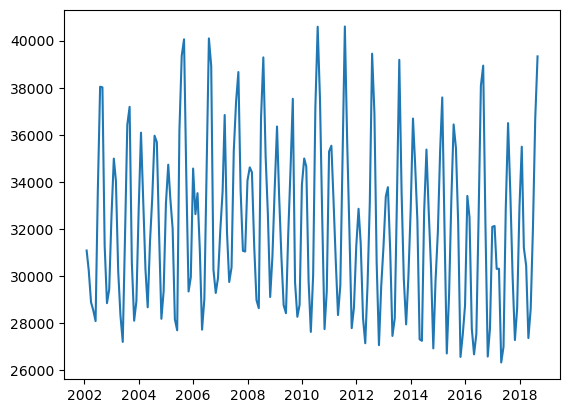

In [11]:
plt.plot(df.resample('1m').mean());

In [12]:
df_day = df['2016-01':'2018-01'].resample('1d').sum()

## Скользящие средние

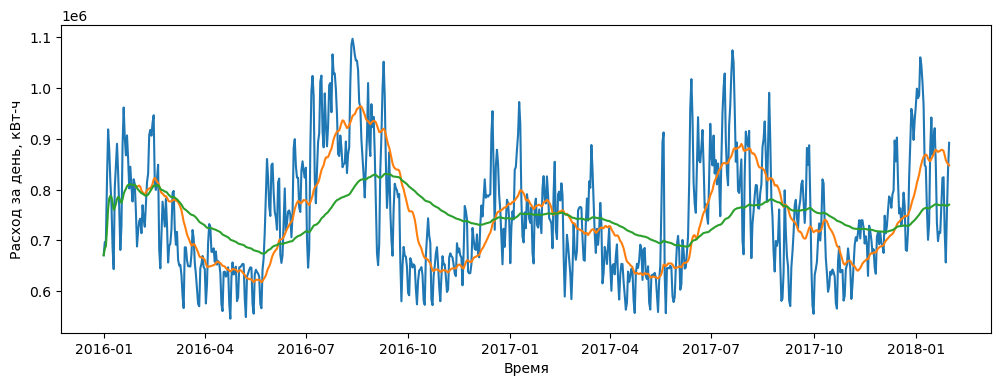

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df_day)
plt.plot(df_day.rolling(30).mean());
plt.plot(df_day.ewm(90).mean());

plt.xlabel('Время')
plt.ylabel('Расход за день, кВт-ч');

## Тренд и сезонность

**Тренд** - плавное изменение среднего без цикличности.

**Сезонность** - цикличные закономерности во временном ряду.

**Стационарным** рядом называется тот, у которого среднее, стандартное отклонение и ковариация со временем не меняются.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
decomposed = seasonal_decompose(df_day) 

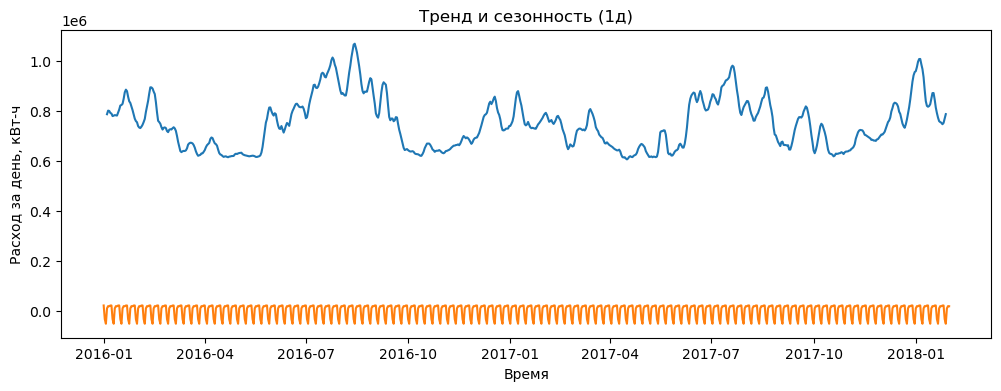

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Тренд и сезонность (1д)')
plt.plot(decomposed.trend);
plt.plot(decomposed.seasonal);
plt.xlabel('Время')
plt.ylabel('Расход за день, кВт-ч');

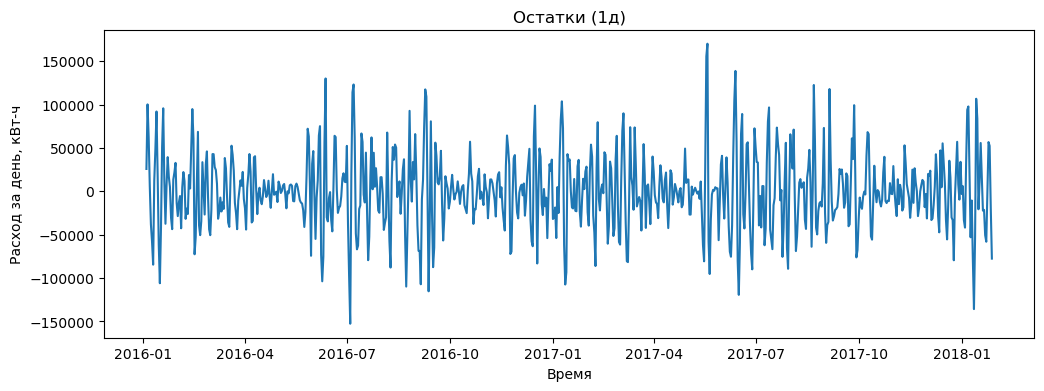

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Остатки (1д)')
plt.plot(decomposed.resid);
plt.xlabel('Время')
plt.ylabel('Расход за день, кВт-ч');

## Проверка на стационарность

Тест Дики-Фуллера: нулевая гипотеза - ряд нестационарен.

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
stat, p, *_ = adfuller(df_day['PJME_MW'])
print(f'P-value: {p:.2f}')
print(f'Результат: {stat:.2f}')
if p < 0.05:
    print ("Отвергаем нулевую гипотезу - ряд стационарный.")
else:
    print ("Не получилось отвергнуть нулевую гипотезу - ряд нестационарный.")

P-value: 0.06
Результат: -2.77
Не получилось отвергнуть нулевую гипотезу - ряд нестационарный.


## Разности

In [20]:
df_day.head()

,PJME_MW
Datetime,
2016-01-01,670751.0
2016-01-02,696432.0
2016-01-03,698803.0
2016-01-04,821012.0
2016-01-05,918751.0


In [21]:
df_day.shift(fill_value=0).head()

,PJME_MW
Datetime,
2016-01-01,0.0
2016-01-02,670751.0
2016-01-03,696432.0
2016-01-04,698803.0
2016-01-05,821012.0


In [22]:
diff = df_day - df_day.shift(fill_value=df_day['PJME_MW'].iloc[0])

In [23]:
decomposed = seasonal_decompose(diff)

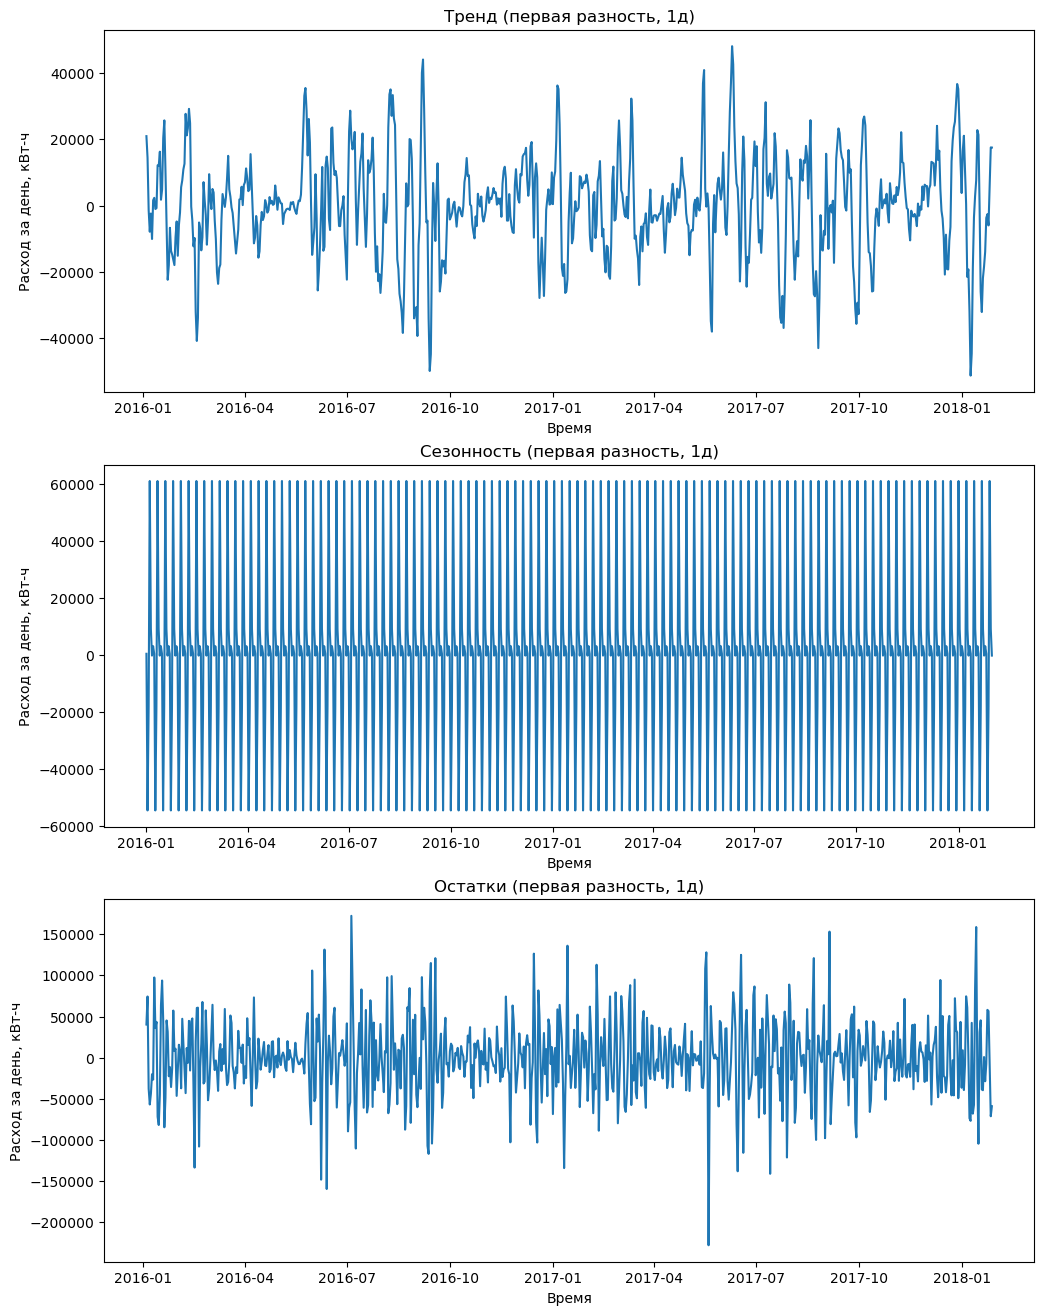

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(12, 16))
ax[0].set(title = 'Тренд (первая разность, 1д)', xlabel='Время', ylabel='Расход за день, кВт-ч')
ax[0].plot(decomposed.trend);
ax[1].set(title = 'Сезонность (первая разность, 1д)', xlabel='Время', ylabel='Расход за день, кВт-ч')
ax[1].plot(decomposed.seasonal);
ax[2].set(title = 'Остатки (первая разность, 1д)', xlabel='Время', ylabel='Расход за день, кВт-ч')
ax[2].plot(decomposed.resid);

In [25]:
stat, p, *_ = adfuller(diff['PJME_MW'])
print(f'P-value: {p}')
print(f'Результат: {stat:.2f}')
if p < 0.05:
    print ("Отвергаем нулевую гипотезу - ряд стационарный.")
else:
    print ("Не получилось отвергнуть нулевую гипотезу - ряд нестационарный.")

P-value: 3.350041943540979e-11
Результат: -7.54
Отвергаем нулевую гипотезу - ряд стационарный.


## Baseline

In [26]:
data = df.resample('1d').sum()

In [27]:
train, test = train_test_split(data, shuffle=False, test_size=0.2)

In [28]:
print(f"Средний объём электропотребления в день: {test['PJME_MW'].mean():.2f} кВт-ч")

Средний объём электропотребления в день: 745523.45 кВт-ч


### На базе среднего/медианы

In [29]:
print(f"MAE: {mean_absolute_error(test['PJME_MW'], np.ones(test.shape) * train['PJME_MW'].median()):.2f}")
print(f"MSE: {mean_squared_error(test['PJME_MW'], np.ones(test.shape) * train['PJME_MW'].median()):.2f}")

MAE: 96625.08
MSE: 13784856759.72


### На базе вчерашнего дня

In [30]:
yesterday = test.shift(fill_value=0)
yesterday.iloc[0] = train.iloc[-1]

In [31]:
print(f"MAE: {mean_absolute_error(test['PJME_MW'], yesterday):.2f}")
print(f"MSE: {mean_squared_error(test['PJME_MW'], yesterday):.2f}")

MAE: 44941.66
MSE: 4115954937.66


## Классический подход к решению

Классические методы включают в модель подмножество следующих компонентов:

- авторегрессия (AR): линейная регрессия следующей точки по нескольким предыдущим;
- так называемый MA-процесс: регрессия ошибки по предыдущим ошибкам;
- сведение ряда к более стационарному с помощью разностей и/или логарифмирования.

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
model = ARIMA(train, order=(7, 0, 7)).fit()

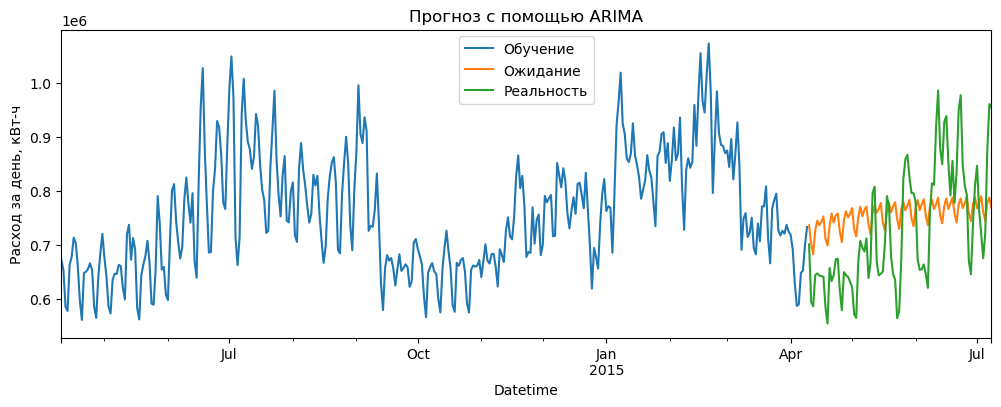

In [90]:
fig, axes = plt.subplots(figsize=(12,4))
train[-365:].plot(ax=axes)
model.forecast(90).plot(ax=axes);
test[:90].plot(ax=axes)
axes.set(ylabel='Расход за день, кВт-ч', title='Прогноз с помощью ARIMA');
axes.legend(['Обучение', 'Ожидание', 'Реальность']);

## Графики автокорреляции

In [35]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

Предыдущие значения за пределами синей зоны информативны.

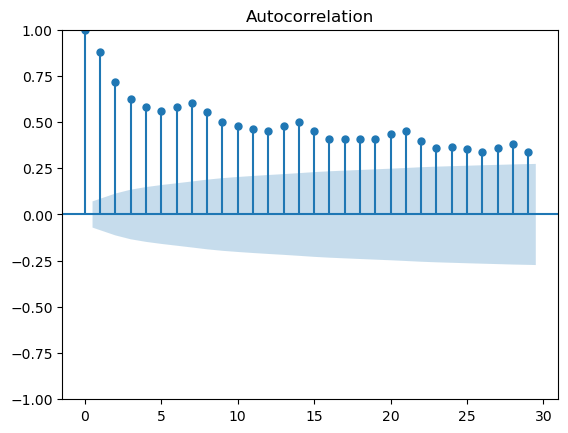

In [36]:
plot_acf(df_day);

Предыдущие ошибки за пределами синей зоны информативны.

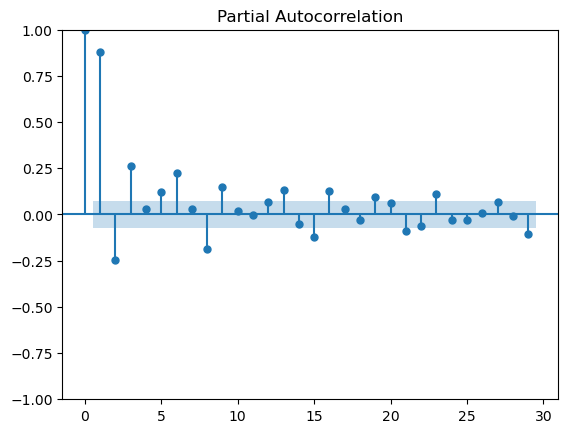

In [37]:
plot_pacf(df_day, method='ywm');

## Оценка модели на базе информационного критерия

При сравнении моделей для временных рядов часто используется **критерий Акаике**:

$$
AIC = 2k - 2ln(L)
$$

Где k - число параметров модели, а L - функция правдоподобия (исходим из допущения, что ошибки модели распределены нормально). Чем эта метрика меньше, тем лучше.

In [38]:
model.aic

117531.74473955756

## Модель Хольта-Уинтерса

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [131]:
model_es = ExponentialSmoothing(endog=train, trend='add', seasonal='add', seasonal_periods=365, damped_trend=True, use_boxcox=True)

In [206]:
fit_es = model_es.fit(optimized=True, remove_bias=False)

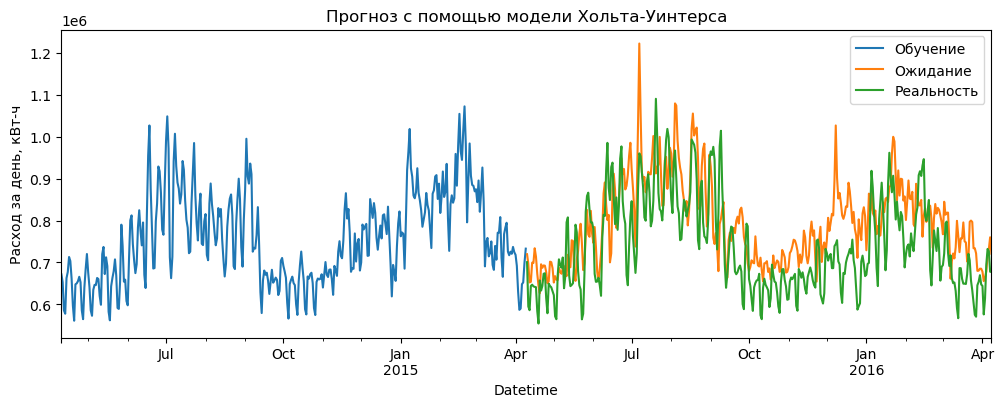

In [204]:
fig, axes = plt.subplots(figsize=(12,4))
train[-365:].plot(ax=axes)
fit_es.forecast(365).plot(ax=axes);
test[:365].plot(ax=axes)
axes.set(ylabel='Расход за день, кВт-ч', title='Прогноз с помощью модели Хольта-Уинтерса');
axes.legend(['Обучение', 'Ожидание', 'Реальность']);

In [205]:
fit_es.aic

109078.60443977817

## Используем sklearn

### Feature engineering

In [39]:
data['year'] = data.index.year
data['month'] = data.index.month
#data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

In [40]:
data.head()

,PJME_MW,year,month,dayofweek
Datetime,,,,
2002-01-01,714857.0,2002,1,1
2002-01-02,822277.0,2002,1,2
2002-01-03,828285.0,2002,1,3
2002-01-04,809171.0,2002,1,4
2002-01-05,729723.0,2002,1,5


In [41]:
max_lag = 7

In [42]:
for i in range(1, max_lag+1):
    data['lag_'+str(i)] = data['PJME_MW'].shift(i)

In [43]:
data['MA7'] = data['PJME_MW'].shift().rolling(7).mean()

In [44]:
data.head()

,PJME_MW,year,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,MA7
Datetime,,,,,,,,,,,,
2002-01-01,714857.0,2002,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-02,822277.0,2002,1,2,714857.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,828285.0,2002,1,3,822277.0,714857.0,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-04,809171.0,2002,1,4,828285.0,822277.0,714857.0,NaN,NaN,NaN,NaN,NaN
2002-01-05,729723.0,2002,1,5,809171.0,828285.0,822277.0,714857.0,NaN,NaN,NaN,NaN


In [45]:
data = data.dropna()

### Моделирование

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('PJME_MW', axis=1), data['PJME_MW'], shuffle=False, test_size=0.2)

In [47]:
model = LinearRegression()

model.fit(X_train, y_train)

print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.2f}")
print(f"MSE: {mean_squared_error(y_test, model.predict(X_test)):.2f}")
print(f"R2: {r2_score(y_test, model.predict(X_test)):.2f}")

MAE: 36831.85
MSE: 2868737019.65
R2: 0.79


In [48]:
predictions = pd.Series(model.predict(X_test), index=y_test.index)

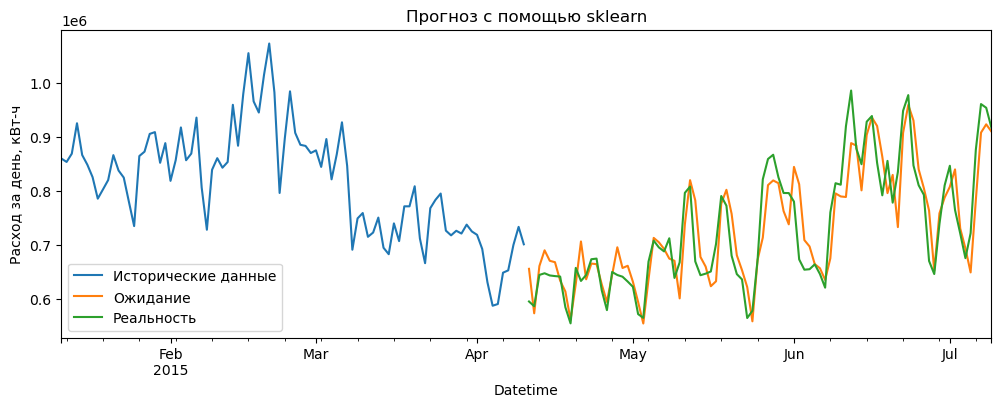

In [49]:
fig, axes = plt.subplots(figsize=(12,4))
y_train[-90:].plot(ax=axes)
predictions[:90].plot(ax=axes)
y_test[:90].plot(ax=axes)
axes.legend(['Исторические данные', 'Ожидание', 'Реальность'])
axes.set(ylabel='Расход за день, кВт-ч', title='Прогноз с помощью sklearn');

### Оценим AIC для нашей модели!

In [50]:
# Стандартизируем ошибки:
errors = y_test - predictions
normalized_errors = StandardScaler().fit_transform(errors.values.reshape(-1, 1))

# Сложим логарифмы их вероятностей на стандартном нормальном распределении:
log_likelihood = np.sum(st.norm.logpdf(normalized_errors))

num_params = model.coef_.size + 1
2 * num_params - 2 * log_likelihood

3460.669127421718

### Кросс-валидация для временных рядов

Важно, чтобы модель обучалась на прошлом и предсказывала будущее, а не наоборот. Чтобы гарантировать это при кросс-валидации, вам понадобится `TimeSeriesSplit()` из `sklearn.model_selection`. При подборе гиперпараметров нужно указать соответствующее разбиение,  например, так:

In [51]:
params = {}

tscv = TimeSeriesSplit(n_splits=8)
gcv = GridSearchCV (estimator=model, param_grid=params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Домашнее задание

Вам предстоит работать с данными по продажам 4 продуктов в 6 странах по 2 магазинам.

**Easy**: постройте модель sklearn для предсказания продаж одного из продуктов в одной стране за последний год по предыдущим данным.

**Medium**: проведите исследовательский анализ, распишите найденные изменения методологии, которые могут осложнить прогнозирование. Обработайте данные, извлеките признаки и постройте соответствующую модель (или отдельные модели) для пронозирования продаж по продуктам, странам и магазинам.

**Hard**: мы исходили из предположения, что нам доступны данные вплоть до текущего дня. Предположим, что у нас есть большая закрытая тестовая выборка - для нее мы не сможем построить отстающие значения. Попробуйте извлечь признаки из исторических данных, которые не потребуют знания продаж за последние дни, и построить соответствующую модель.

In [52]:
df = pd.read_csv('kaggle_sales.csv')

In [53]:
df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


Ввиду небольшого разброса рекомендуется оценивать модели по метрике SMAPE:

$$
SMAPE = \frac{1}{n} \sum_n {\frac{2|y-\hat y|}{|y|+|\hat y|}} \cdot 100 \%
$$

In [54]:
def smape(target, predictions):
    result = np.mean(np.nan_to_num(abs(target - predictions) / ((abs(target)+abs(predictions))/2), posinf=0)) * 100.
    return result

In [55]:
# Скорер для кросс-валидации:
smape_score = make_scorer(smape, greater_is_better=False)

Пример тестовой выборки для Hard:

In [56]:
df_test = pd.read_csv('kaggle_sales_test.csv')

In [57]:
df_test

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book
